## Methods in Linear Regression

In this lab we will canvas various techniques in linear regression analysis and apply them to the numerical variable in the Ames dataset. Some of the techniques, like Ridge Regression and Lasso Regression are already implemented in sci-kit learn, or statsmodels.api but some, like best subset regression, are not. 

In this lab, we'll be looking at __Multilinear regression__, __Best Subset Selection__, __Forward Subset regression__, __Ridge Regression__ and __Lasso Regression__. We will be comparing these models using the number of degrees of freedom. We will be benchmarking these techniques using cross validation, that is by splitting our data into a training set and a test set and comparing the score on the test set. 

#### Getting back to where we were

Lets quickly download the Ames dataset and throw out the outliers recommended in the documentation. Recall

<div class="alert alert-block alert-info">
SPECIAL NOTES:<br>
There are 5 observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will indicate them quickly). Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these 5 unusual observations) before assigning it to students.<br><br>

http://jse.amstat.org/v19n3/decock/DataDocumentation.txt
</div>

Lets load in our standard libraries and dataset:

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

ames = pd.read_csv('https://raw.githubusercontent.com/hjhuney/Data/master/AmesHousing/train.csv')
ames.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Our first job is to clean the outlier mentioned in the documentation for the Ames dataset. We will follow their suggestion and remove all houses over 4000 square feet of above ground living area.

In [7]:
z = ames['GrLivArea']+ames['BsmtUnfSF']<4000
print("Number of records removed:",len(ames) - sum(z))
data = ames[z]

Number of records removed: 24


Indeed, we can check quickly and see that this removes our weird outliers from before.

Text(0.5,1,'Cleaned Data')

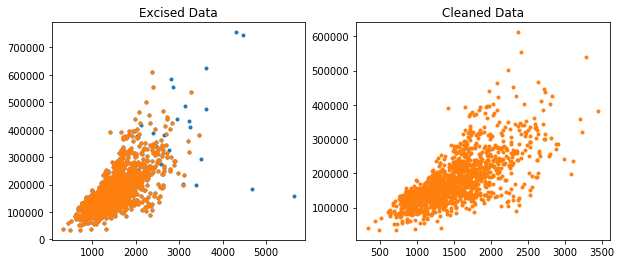

In [29]:
f, axes = plt.subplots(1,2)
f.set_size_inches(10,4)

axes[0].plot(ames['GrLivArea'],ames['SalePrice'],'.')
axes[0].plot(data['GrLivArea'],data['SalePrice'],'.')
axes[1].plot(data['GrLivArea'],data['SalePrice'],'.',color="C1")

axes[0].set_title("Excised Data")
axes[1].set_title("Cleaned Data")

#### Removing categorical  variables

The next step is to cut out all of the categorical variables. There are ways to use regression to fit categorical variables but we will not be focusing on those methods in this lab. As before we will do this using the `DataFrame.include` function and only including the numerical data types `int64` and `float64`.

In [30]:
data = data.select_dtypes(include=['int64','float64'])
display(data.head(5))

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


It is worth going through the documentation and checking if any of the variables are numeric according to python actually represent categorical variable (like error codes, phone number prefixes, etc).  In fact, we the documentation tells us that __MSSubClass__ is a categorical variable, with each number representing a zoning code. We should drop it using `DataFrame.drop()`.

* `DataFrame.drop(columns=[,])` drops a column by name, or a list of columns of by name. It then returns the new dataframe which must be saved into a variable. `drop` can also be used to drop rows. 

In addition, __ID__ is just a label and could be dropped. It should be noted that the ML school of though would actually caution against us dropping these indices. The idea is very much "throw in all the data, maybe there's some correlation there we don't see." We will drop the data for this lab just for practice.  

In [38]:
data = data.drop(columns='MSSubClass')
data.head(5)

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,2,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,3,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,4,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,5,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


## Cross validation

We will now split our data into a training set and a test set. This can be done by hand, but there are also many libraries to perform the split for you. Finally, you could of course write your own function if there's a preferred  way you would like the split done.

We will first do it manually, using the `DataFrame.sample` function to pull out 100 random indices.

* `DataFrame.sample(n=None, frac=None, replace=True, random_state=None)` Sample elements of the dataframe, if `n` is specified it returns a number of elements from the dataframe, if `frac` is specified it returns a fraction of the dataframe. The `replace` determines whether the sampling is done with or without replacement. It can be set to `False` but defaults to `True`. The `random_state` parameter is a random seed.  

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html

In [75]:
Test_Size = 1300

train=data.sample(n=Test_Size,replace=False,random_state=200)
test=data.drop(train.index)

print("Train Shape", train.shape)
print("Test Shape", test.shape)

Train Shape (1300, 37)
Test Shape (136, 37)


We then split the train and test into input and target data.

In [76]:
X_train = train.drop(columns=['SalePrice','Id'])
Y_train = train['SalePrice']

X_test = test.drop(columns=['SalePrice','Id'])
Y_test = test['SalePrice']

## Linear Regression

We now want to perform our first predictions using linear regression. We will do a quick one variable fit both using linear algebra and then using the sci-kit learn library and compare the fits. 

For a single feature, we want to fit a 2 vector of constants $[\beta_0,\beta_1]$ to 
$$
Y = \beta_0 + X\beta_1 = {X}^T\beta = [1,X] \left[ \begin{matrix} \beta_0\\\beta_1 \end{matrix} \right] \,.
$$
The solution will be given by
$$
\beta = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}\,,
$$
where $\mathbf{X}$ is the vector where each column is $[1,x_i]$ contains the $x_i$'s measured feature and $\mathbf{y}$ is a vector of target values.

We will convert the dataframes __X_train__ and __Y_train__ to an `numpy` matrices __X__ and __y__ respectively to perform this calculation, but lets start with one variable. We will try to fit __1stFlrSF__ to __SalePrice __.

In [103]:
X = np.matrix(X_train['1stFlrSF'])
Y = np.matrix(Y_train)

# Check the shape, they need to be column vectors.

print("X shape",X.shape)
print("Y shape",Y.shape)

X shape (1, 1300)
Y shape (1, 1300)


We need to reshape these vectors into column vectors. When using reshape, you're always constrained by the fact that the new matrix shape needs to be compatible with the old shape. Practically, that means we can let Python figure out one dimension for us. You specify the dependent dimension by -1. For example,

`DataFrame.reshape(-1,1)` return a vector with 1 row and however many columns are required to match the original shape. 

In [104]:
X = X.reshape(-1,1)
Y = Y.reshape(-1,1)

Y.shape

(1300, 1)

Now, we add a column of 1's for the affine term

In [105]:
Xa = np.append(np.ones(X.shape),X,1)

And compute beta.

In [113]:
betas = (Xa.T*Xa).I*Xa.T*Y
print(betas)

[[34157.21426247]
 [  124.95802909]]


We now plot the data against the fit line.

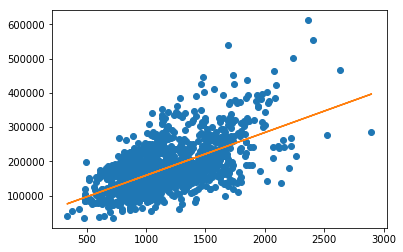

In [112]:
plt.plot(X,Y,'o')
plt.plot(X,Xa*betas)

Lets check how we did on our test set, both with a graph and numerically. Graphically, we can just plot the regression line again the test data scatter plot. We can evaluate the model numerically but computing the residual sum squared
$$
RSS(\beta) = \sum_{i=1}^N (y_i - x_i^T\beta)^2\,,
$$
the root mean square
$$
RMS(\beta) = \left(\frac{1}{N}(y_i - x_i^T\beta)^2\right)^{\frac12}\,,
$$
and the $r^2$ value
$$
r^2 = 1 - \frac{RSS(\beta)}{\sum_{i=1}^N (y_i - E[y])^2}\,.
$$

Lets set up the matrices for the test data.

In [121]:
XT = np.matrix(X_test['1stFlrSF']).reshape(-1,1)
XTa = np.append(np.ones(XT.shape), XT,1)

YT = np.matrix(Y_test).reshape(-1,1)

In [131]:
RSS = (YT - XTa*betas).T*(YT - XTa*betas)
RMS = np.sqrt(RSS/len(YT))
print("The Residual Sum Square is", RSS)
print("The Root Mean Square is", RMS)

Rsq = 1 - RSS/((YT - YT.mean()).T*(YT - YT.mean()))

print("R^2 Score is", Rsq)

The Residual Sum Square is [[4.53133854e+11]]
The Root Mean Square is [[57722.32301199]]
R^2 Score is [[0.25973528]]


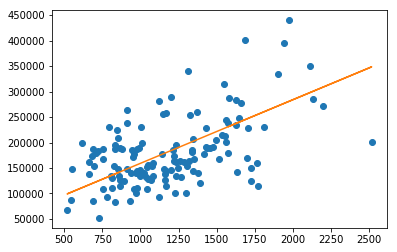

In [135]:
plt.plot(XT,YT,'o')
plt.plot(XT,XTa*betas)

Now lets use sci-kit learns built in regression function. We import `LinearRegression` from `sklearn.linear_model`, the toolkit of linear models in sci-kit learn. We then set up a linear regression object using

`lr = LinearRegression()`

An object like a linear regression object is a structure like a dataframe. It stores data, but also has a series of utility function associated with it. It is a self contained machine that we can put data into, turn a crank (by calling functions) and have it process and return that data. In this case, it takes in training data and fits a linear regressor to it. We can then ask it return the parameters of that regressor with 

* `lr.coef_` Returns the slope coefficients of regression $\beta_1,\ldots, \beta_p$.
* `lr.intercept_` Returns the intercept of regression $\beta_0$.
* `lr.score(X_data,Y_data)` Returns the $r^2$ score on `X_data` and `Y_data`.

Note, that `LinearRegression` wants the data in the form we've been using in class: the $X$ data should be a $N$ by $p$ matrix of data points and the $y$ data should be a $N$ by 1 column vector. 

In [138]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X,Y)

print([lr.coef_,lr.intercept_])
print(lr.score(XT,YT))

[array([[124.95802909]]), array([34157.21426247])]
0.25973527738036517


#### Regression with statsmodels.api

Although in this class we will be focusing on sci-kit learn, there's another important statistics library to be aware of, statsmodels.api. For regression in particular, statsmodels.api is just a much better tool, performing all of the statistical analysis you would like. The only caveat is that stats model doesn't naturally fit to a constant term, so we must again add a column of 1's. But statsmodels.api has a function to preform that task.

* `sm.OLS(Y_Data, X_data)` OLS returns an ordinary least squares object which can then be fit with `ols.fit()`. The fit object returned by `ols.fit()` has a robust `.summary()` method that gives all us rich and detailed information about the regression fit.

Note: in addition to fitting, OLS has functions to deal with missing values and built in ridge and lasso regression functions. 

In [139]:
import statsmodels.api as sm

ols = sm.OLS(Y, Xa)
ols_result = ols.fit()

ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     792.1
Date:                Thu, 07 Feb 2019   Prob (F-statistic):          1.90e-136
Time:                        19:53:22   Log-Likelihood:                -16079.
No. Observations:                1300   AIC:                         3.216e+04
Df Residuals:                    1298   BIC:                         3.217e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.416e+04   5312.813      6.429      0.000    2.37e+04    4.46e+04
x1           124.9580      4.440     28.145      0.000     116.248     133.668
==============================================================================
Omnibus:                      175.485   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              313.081
Skew:                           0.858   Prob(JB):                     1.04e-68
Kurtosis:                       4.683   Cond. No.                     4.02e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Multilinear Regression: Cleaning Data

It actually often takes less computational time to compute a linear regression than it does to plot it. We want to fit the set of training data with all the numerical features to the sale price, but before we do we have to deal with those `NaN` values. For example, if we just try to compute the linear regression now it will return an error. 

Now, lets try to train against all of `X_train` and `Y_train` using sci-kit learn.

In [ ]:
lr = LinearRegression()
lr.fit(X_train,Y_train)

Fixing missing values is fiddly, and should be done with care. Whatever choice you make will effect your fit, and as a result will effect your accuracy. In general, data cleaning is the usually more than half the battle. 

To find the `NaN` values, we will use the `DataFrame.isnull().sum()` to return all of the null values, and them sum them along columns. 

In [144]:
data.isnull().sum()

Id                 0
LotFrontage      258
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       79
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
SalePrice          0
dtype: int64

We find that __LotFrontage__, __MasVnrArea__, and __GarageYrBlt__ are the only numerical features with null values. Lets take a look at each of these values individually. After we make a choice for each variable, we will use

* `DataFrame.fillna(Value, inplace=True)` fills all of the `NaN` values in an array with the contents of `Value`. 

__MasVnrArea__ is "Masonry veneer area in square feet". Dumping the data we find a lot of zero values, so its probably safe to assume that 8 values can be set to 0 or the median value. 

In [149]:
data["MasVnrArea"].fillna(0,inplace=True)
data.MasVnrArea.isnull().sum()

0

For __GarageYrBlt__, a value of `NaN` probably means there's no garage. Lets check just to make sure by looking at the __GarageArea__ variable for every `NaN` value.

In [154]:
sum(data["GarageArea"][data["GarageYrBlt"].isnull()])

0

In [156]:
data["GarageYrBlt"].fillna(0,inplace=True)

Finally, for __LotFrontage__ we assume that almost every lot has some frontage road so we don't want to set this to 0. There are more sophisticated solutions, but the simplest is just to find the median value and set the null values to it. 

In [159]:
m = np.median((data["LotFrontage"][data["LotFrontage"].notnull()]))

data["LotFrontage"].fillna(m, inplace=True)
data.MasVnrArea.isnull().sum()

0

Finally, lets check to make sure we've elemented all missing values.

In [162]:
data.isnull().sum().sum()

0

### Cross validation and Fitting
We now reestablish our train/test split

In [2]:
Test_Size = 1000

train=data.sample(n=Test_Size,replace=False)
test=data.drop(train.index)

print("Train Shape", train.shape)
print("Test Shape", test.shape)

X_train = train.drop(columns=['SalePrice','Id'])
Y_train = train['SalePrice']

X_test = test.drop(columns=['SalePrice','Id'])
Y_test = test['SalePrice']

NameError: name 'data' is not defined

And train the data using statsmodels.api. Remember that we have to add a column to `X_train` to account for the constant term. Luckily, statsmodels has built in function for that `sm.add_constant(X_data)`

In [436]:
ols = sm.OLS(Y_train, sm.add_constant(X_train))
ols_result = ols.fit()

ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     200.5
Date:                Fri, 08 Feb 2019   Prob (F-statistic):               0.00
Time:                        11:59:33   Log-Likelihood:                -11581.
No. Observations:                1000   AIC:                         2.323e+04
Df Residuals:                     966   BIC:                         2.340e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -8.955e+05    1.3e+06     -0.692      0.489   -3.44e+06    1.65e+06
LotFrontage     145.9581     44.637      3.270      0.001      58.362     233.554
LotArea           0.4446      0.092      4.817      0.000       0.264       0.626
OverallQual     1.43e+04   1101.852     12.981      0.000    1.21e+04    1.65e+04
OverallCond    5557.1937    956.996      5.807      0.000    3679.163    7435.224
YearBuilt       377.2016     56.453      6.682      0.000     266.416     487.987
YearRemodAdd    212.9811     61.793      3.447      0.001      91.718     334.245
MasVnrArea       19.1499      5.405      3.543      0.000       8.543      29.757
BsmtFinSF1       21.8876      2.385      9.177      0.000      17.207      26.568
BsmtFinSF2        4.2106      4.097      1.028      0.304      -3.829      12.251
BsmtUnfSF        -2.2697      2.250     -1.009      0.313      -6.686       2.146
TotalBsmtSF      23.8284      3.269      7.289      0.000      17.413      30.244
1stFlrSF         27.9397      6.177      4.523      0.000      15.818      40.062
2ndFlrSF         27.3346      5.894      4.637      0.000      15.767      38.902
LowQualFinSF    -35.5264     15.360     -2.313      0.021     -65.670      -5.383
GrLivArea        19.7479      5.718      3.453      0.001       8.526      30.970
BsmtFullBath   -553.9998   2445.910     -0.227      0.821   -5353.909    4245.910
BsmtHalfBath  -7086.7936   3730.556     -1.900      0.058   -1.44e+04     234.135
FullBath      -3070.2648   2705.427     -1.135      0.257   -8379.457    2238.928
HalfBath       -779.1078   2497.409     -0.312      0.755   -5680.080    4121.864
BedroomAbvGr  -1.041e+04   1577.858     -6.596      0.000   -1.35e+04   -7311.176
KitchenAbvGr  -2.754e+04   4527.258     -6.083      0.000   -3.64e+04   -1.87e+04
TotRmsAbvGrd   6320.4257   1165.511      5.423      0.000    4033.201    8607.650
Fireplaces     2992.4382   1590.990      1.881      0.060    -129.757    6114.633
GarageYrBlt     -10.9101      2.489     -4.383      0.000     -15.795      -6.025
GarageCars     4547.3731   2916.993      1.559      0.119   -1177.001    1.03e+04
GarageArea       32.0966      9.190      3.492      0.001      14.061      50.132
WoodDeckSF        4.1460      7.436      0.558      0.577     -10.446      18.738
OpenPorchSF      20.6363     14.206      1.453      0.147      -7.241      48.514
EnclosedPorch     1.1265     15.779      0.071      0.943     -29.838      32.091
3SsnPorch       -29.8779     31.646     -0.944      0.345     -91.980      32.224
ScreenPorch      20.8138     15.998      1.301      0.194     -10.582      52.210
PoolArea        -42.8512     28.456     -1.506      0.132     -98.694      12.991
MiscVal          -0.9432      1.439     -0.656      0.512      -3.766       1.880
MoSold          428.9039    313.417      1.368   

Now we want to score this model on test data. Unfortunately statsmodels.api doesn't have a built in test function, but we can use our own pretty easily. 

In [452]:
def RSS(y,Y):
    y = np.matrix(y).reshape(-1,1)
    Y = np.matrix(Y).reshape(-1,1)
    
    return (y-Y).T*(y-Y)

def RMS(y,Y):    
    return np.sqrt(RSS(y,Y))/len(y)

def Rs(y,Y): 
    y = np.matrix(y).reshape(-1,1)
    Y = np.matrix(Y).reshape(-1,1)
    
    return 1 - RSS(y,Y)/((Y - np.mean(Y)).T*(Y - Y.mean()))

In [557]:
pred = ols_result.predict(sm.add_constant(X_test))
Rs(pred, Y_test)
#RMS(pred, Y_test)

matrix([[0.86170171]])

## Ridge Regression and Lasso Regression

Now that we have a baseline, we try out our new methods. We will actually be look at ridge regression and lasso regression first, since they are actually implemented and so easier to code in. 

An `statsmodel.api.ols` object has a regularized regression fit function `ols.fit_regualrized()` that implements both lasso and ridge regression. In fact, it minimizes the loss function

$$
\textbf{Loss}(\beta) = \frac{1}{2n}\textbf{RSS} + \alpha\left(\frac{(1-\lambda)}{2}\sum_i \beta_i^2 + \lambda\sum_i|\beta_i|\right)
$$

This linear combination of loss functions is known as __elastic net regression__. For a little demo of the interpolation between the bounded regions for the variables take a look at this Desmos applet:

https://www.desmos.com/calculator/a4a6qgitr7

The `ols.fit_regualrized()` takes the following form, where $\lambda$ is `L1_wt`:

* `OLS.fit_regularized(alpha=0.0, L1_wt=1.0, start_params=None)` Here, `alpha` is the overall weight $\alpha$ and `L1_wt` is the coefficient of the $L_1$ norm. 

## Ridge Regression

First, lets compute the ridge regression. Note that not all of the functionality has been added to statsmodels.api's OLS class yet. In particular, summary doesn't work. But we can still compute $r^2$ values on the test set using the functions we defined above. Pick a value at random, let's compute with $\alpha = 1$

In [439]:
ols = sm.OLS(Y_train, sm.add_constant(X_train))
ols_result = ols.fit_regularized(L1_wt=0,alpha=1)

Rs(ols_result.predict(sm.add_constant(X_test)),Y_test)

matrix([[0.84559559]])

We're probably already doing worse than expected. Lets predict for 50 $\alpha$ values from 0 to 1. We will save the $r^2$ value in in a list, by creating an empty list and appending each value into it. 

In [440]:
r_sqds = []
alphas = np.linspace(0,.1,50)

for alp in alphas:
    ols = sm.OLS(Y_train, sm.add_constant(X_train))
    ols_result = ols.fit_regularized(L1_wt=0,alpha=alp)

    r_sqds.append(Rs(ols_result.predict(sm.add_constant(X_test)),Y_test).A1)

0.8656111060426488


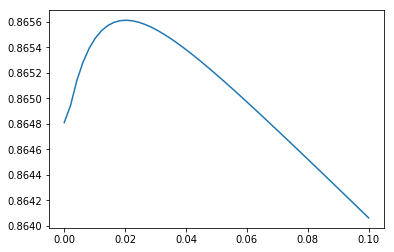

In [441]:
print(np.max(r_sqds))
plt.plot(alphas, r_sqds)

If we add a few lines of code to save the $\hat \beta$ values at each iteration, you can plot them again each other. Of course, the vast difference in $\hat \beta$ values we saw in the ordinary linear regression model indicates that they wont be very meaningful on the same graph (the largest are on the order of $10^6$, the smallest on the order of $10^{-1}$). 

The simplest way to overcome this, if we are just interested in the dynamics of the variables, is to normalize the largest $|\beta_i^{\alpha}|$ to 1 for each feature. This can be done by dividing by the max of the absolute value. 

In [442]:
r_sqds = []
betas = pd.DataFrame(columns=["Coeff"]+list(X_train))
alphas = np.linspace(0,.1,50)

for alp in alphas:
    ols = sm.OLS(Y_train, sm.add_constant(X_train))
    ols_result = ols.fit_regularized(L1_wt=0,alpha=alp)

    r_sqds.append(Rs(ols_result.predict(sm.add_constant(X_test)),Y_test).A1)
    beta = pd.DataFrame(ols_result.params.reshape(1,-1),columns=["Coeff"]+list(X_train))
    betas = betas.append(beta)

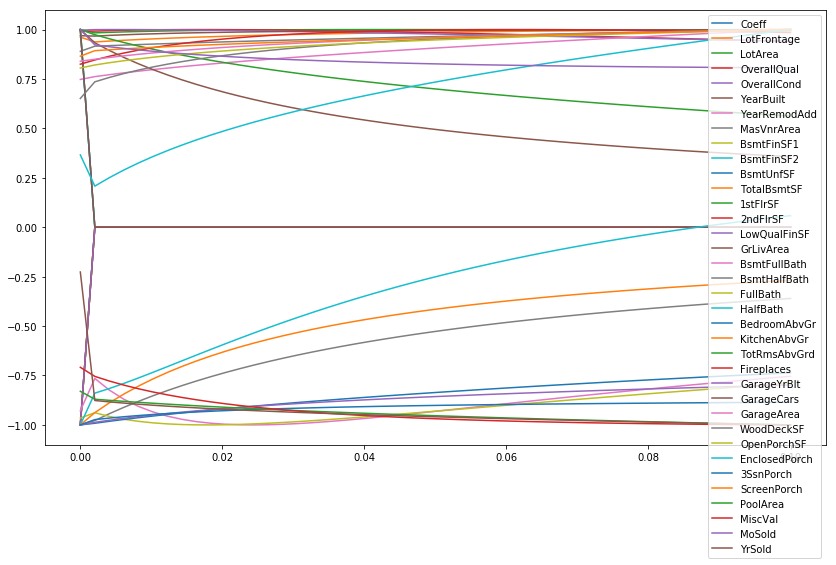

In [443]:
f, axes = plt.subplots()
f.set_size_inches(14,8)

plt.plot(alphas,betas/betas.abs().max())
plt.legend(["Coeff"]+list(X_train))

## Lasso Regression

To compute the Lasso regression we can recycle our code from above, but now we set `L1_wt=1`, turning off the ridge parameters and turning of the Lasso. We will also have to modify our $alpha$ values since the $\beta$ are penalized much less for being large. 

In [581]:
r_sqds = []
rss_s = []
betas = pd.DataFrame(columns=["Coeff"]+list(X_train))
alphas = np.linspace(600,1200,20)

for alp in alphas:
    ols = sm.OLS(Y_train, sm.add_constant(X_train))
    ols_result = ols.fit_regularized(L1_wt=1,alpha=alp)

    r_sqds.append(Rs(ols_result.predict(sm.add_constant(X_test)),Y_test).A1)
    rss_s.append(RMS(ols_result.predict(sm.add_constant(X_test)),Y_test).A1)
    beta = pd.DataFrame(np.array(ols_result.params).reshape(1,-1),columns=["Coeff"]+list(X_train))
    betas = betas.append(beta)

0.844824891037047
1335.256622057908


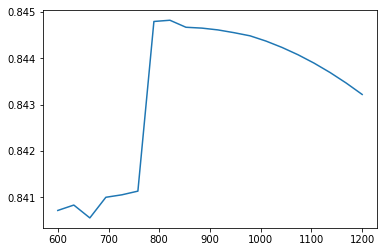

In [574]:
print(np.max(r_sqds))
print(np.max(rss_s))
plt.plot(alphas, r_sqds)

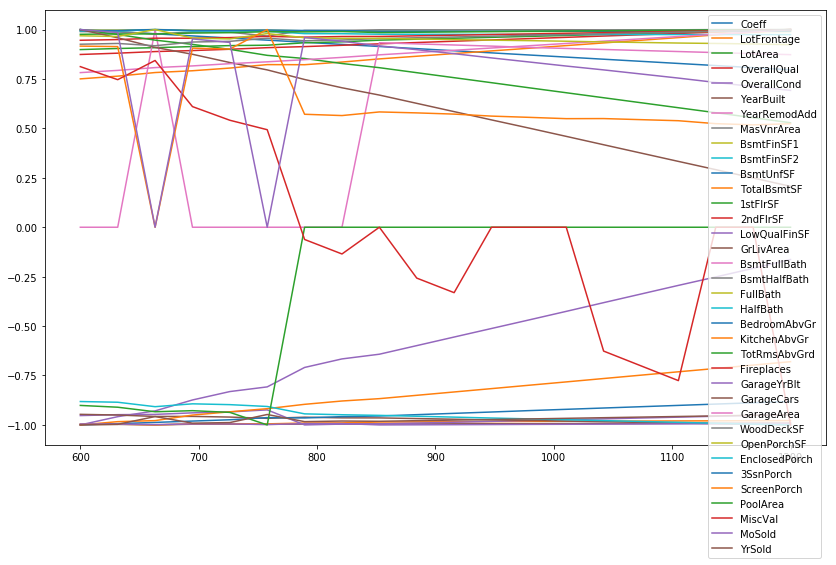

In [582]:
f, axes = plt.subplots()
f.set_size_inches(14,8)

plt.plot(alphas,betas/betas.abs().max())
plt.legend(["Coeff"]+list(X_train))

# Subset Selection:

We will implement subset selection algorithms. Before we could lean on built in libraries, but we will now have to implement the algorithms ourselves. Luckily, subset selection is a relatively straight forward idea. 

## Forward subset selection:

We will begin with forward subset selection. The idea is to greedily add variables to our fitting, starting with the best single variable predictor and adding new variables one at a time. 

We will implement a function that returns the best predictor to add to a list of preselected predictors. This function will take the form

* `best_predict(inc, X_train, Y_train)` Where `inc` is a list of predictors that we have already included.

In [546]:
def best_predict(inc, X_train, Y_train, X_test,Y_test):
    rem_pred = [p for p in X_train.columns if p not in inc]
    
    RSquared = []
    Columns = []
    
    for p in rem_pred:
        olst = sm.OLS(Y_train, sm.add_constant(X_train[inc+[p]]))
        olst_result = olst.fit()    
        olst_result.predict(sm.add_constant(X_test[inc+[p]]))
        RSquared.append(Rs(olst_result.predict(sm.add_constant(X_test[inc+[p]])),Y_test))
        Columns.append(inc+[p])
        
    z = RSquared.index(max(RSquared))
    print("Maximum r^2", RSquared[z])
    print("Columns", Columns[z])
    
    return([float(RSquared[z]),Columns[z]])

Maximum r^2 [[0.61135835]]
Columns ['OverallQual']
Maximum r^2 [[0.72455045]]
Columns ['OverallQual', 'GrLivArea']
Maximum r^2 [[0.80003642]]
Columns ['OverallQual', 'GrLivArea', 'BsmtFinSF1']
Maximum r^2 [[0.81792091]]
Columns ['OverallQual', 'GrLivArea', 'BsmtFinSF1', 'GarageCars']
Maximum r^2 [[0.83032508]]
Columns ['OverallQual', 'GrLivArea', 'BsmtFinSF1', 'GarageCars', 'LotArea']
Maximum r^2 [[0.84166883]]
Columns ['OverallQual', 'GrLivArea', 'BsmtFinSF1', 'GarageCars', 'LotArea', 'YearRemodAdd']
Maximum r^2 [[0.84898574]]
Columns ['OverallQual', 'GrLivArea', 'BsmtFinSF1', 'GarageCars', 'LotArea', 'YearRemodAdd', 'TotalBsmtSF']
Maximum r^2 [[0.85591004]]
Columns ['OverallQual', 'GrLivArea', 'BsmtFinSF1', 'GarageCars', 'LotArea', 'YearRemodAdd', 'TotalBsmtSF', 'BedroomAbvGr']
Maximum r^2 [[0.859057]]
Columns ['OverallQual', 'GrLivArea', 'BsmtFinSF1', 'GarageCars', 'LotArea', 'YearRemodAdd', 'TotalBsmtSF', 'BedroomAbvGr', 'LotFrontage']
Maximum r^2 [[0.86151311]]
Columns ['OverallQu

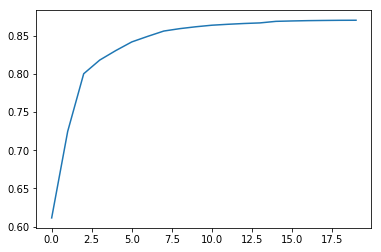

In [556]:
varlist = []
r_list = []

for i in range(0,20):
    r,varlist = best_predict(varlist,X_train, Y_train, X_test, Y_test)
    r_list = r_list + [r]
    
plt.plot(r_list)

## (Extra) Best subset selection:

Best subset selection is impractical on large arrays of variables, but it's good to understand how it can be implemented. The code below uses itertools to iterate over all subsets of the range. Notice though that even for subsets of size 3 it really begins to chug. This naive version of best subset selection shouldn't be used for data sets with this many features. 

In [272]:
import itertools
p = len(list(X_train)) # Number of featuers

names = list(X_train)

for d in range(1,3):

    subsets = list(itertools.combinations(range(0,p), d))
    print(p, "features,", len(subsets),"subsets of length ", d)

    fits = pd.DataFrame(columns=['cols','r sq train','r sq test','parameters'])

    for s in subsets:
        si = [names[i] for i in s]

        lr = LinearRegression()
        lr.fit(X_train[si],Y_train)

        Y_head_lr = lr.predict(X_test[si])
        rtr = Rs(Y_head_lr,Y_test)

        Y_head_lr_train = lr.predict(X_train[si])
        rte = Rs(Y_head_lr_train,Y_train)

        fits = fits.append({'cols':s,'r sq train':rtr,'r sq test':rte,'parameters':lr.coef_},ignore_index=True)
    
    best = fits.sort_values("r sq test",ascending=False).head(1)
    print(best[['cols','r sq train','r sq test']])
    print(best['parameters'])
    print()

35 features, 34 subsets of length  1
   cols            r sq train             r sq test
2  (2,)  [[[[[0.55138458]]]]]  [[[[[0.64189477]]]]]
2    [42992.24844054518]
Name: parameters, dtype: object

35 features, 561 subsets of length  2
       cols            r sq train             r sq test
76  (2, 14)  [[[[[0.64560375]]]]]  [[[[[0.73288166]]]]]
76    [31488.380346397124, 56.23148188331792]
Name: parameters, dtype: object

35 features, 5984 subsets of length  3
            cols            r sq train             r sq test
1144  (2, 7, 14)  [[[[[0.71561515]]]]]  [[[[[0.80046758]]]]]
1144    [28168.719329408694, 45.103526281894105, 55.93...
Name: parameters, dtype: object



(136, 35)

## Exercise:

Find the best single varaible to drop from the full linear linear fit. That is, do one step of backwards subset selection. 

## Exercise:

Keeping in mind that the training/test split was arbitrary, what do you expecct the best method for prediction on the Ames data set to be? Justify your answer. 

## Exercise:

The `ols.fit_regularized(L1_wt=1,alpha=alp)` function alloes us to use eleastic net regression allow us to mix the ridge and lasso methods.

Splitting the data using 

`train=data.sample(n=Test_Size,replace=False, random_state=200)`

where the `random state` seed has been set to 200 will help normalized the results. 